In [ ]:
!pip install -Uqq fastbook

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

In [3]:
path='./data/'

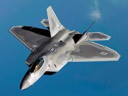

In [4]:
from PIL import Image

im = Image.open(path + 'F-22_Raptor/image_1.jpg')
im.to_thumb(128,128)

In [5]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#846) [Path('data/F-1117_Nighthawk/image_1.jpg'),Path('data/F-1117_Nighthawk/image_10.jpg'),Path('data/F-1117_Nighthawk/image_100.jpg'),Path('data/F-1117_Nighthawk/image_101.jpg'),Path('data/F-1117_Nighthawk/image_102.jpg'),Path('data/F-1117_Nighthawk/image_103.jpg'),Path('data/F-1117_Nighthawk/image_104.jpg'),Path('data/F-1117_Nighthawk/image_105.jpg'),Path('data/F-1117_Nighthawk/image_107.jpg'),Path('data/F-1117_Nighthawk/image_108.jpg')...]

Sanity check on images. Corrupt images check.

In [6]:
failed = verify_images(filenames)
failed

(#0) []

Create own DataLoaders object --> data block API

In [7]:
# Create a DataBlock
fighterjets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [8]:
dls = fighterjets.dataloaders(path)

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Show labeled images

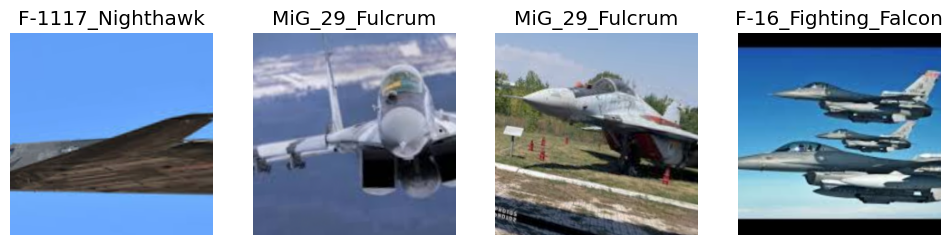

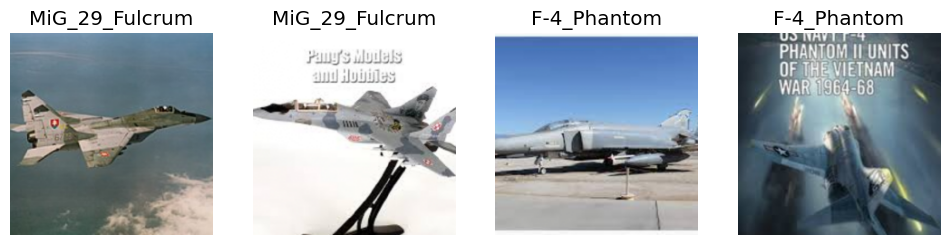

In [9]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Test model using resnet

In [10]:
resnet50_model = vision_learner(dls, resnet50, metrics=error_rate)
resnet50_model.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,2.216146,1.363491,0.443787,01:06


epoch,train_loss,valid_loss,error_rate,time
0,1.186866,1.014954,0.366864,01:22
1,1.116447,0.917026,0.355030,01:22
2,1.003129,0.880425,0.337278,01:23
3,0.894472,0.837428,0.295858,01:24
4,0.816543,0.784518,0.278107,01:24
5,0.731978,0.726501,0.260355,01:24
6,0.650404,0.723789,0.260355,01:25
7,0.588582,0.776081,0.272189,01:24
8,0.533334,0.774803,0.266272,01:25
9,0.481976,0.700303,0.242604,01:26


Training Accuracy: 0.5910
Validation Accuracy: 0.1598


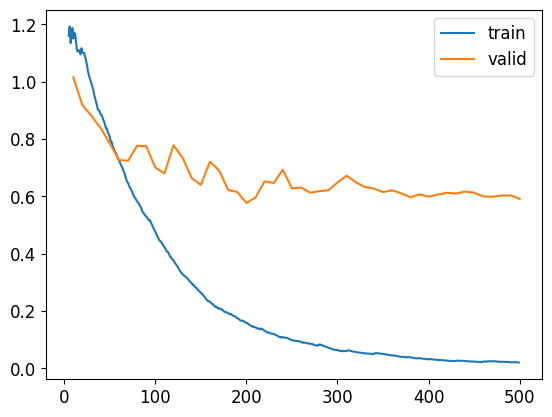

In [11]:
recorder = resnet50_model.recorder

# Print the training and validation accuracy
train_acc = recorder.values[-1][1]  # Training accuracy (last epoch)
valid_acc = recorder.values[-1][2]  # Validation accuracy (last epoch)

print(f'Training Accuracy: {train_acc:.4f}')
print(f'Validation Accuracy: {valid_acc:.4f}')

# Plot the training and validation accuracy
recorder.plot_loss()

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


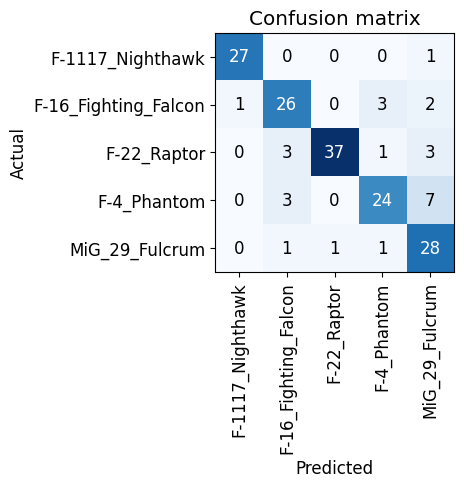

In [12]:
interp = ClassificationInterpretation.from_learner(resnet50_model)
interp.plot_confusion_matrix()

In [13]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

NameError: name 'our_out_of_the_box_model' is not defined

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


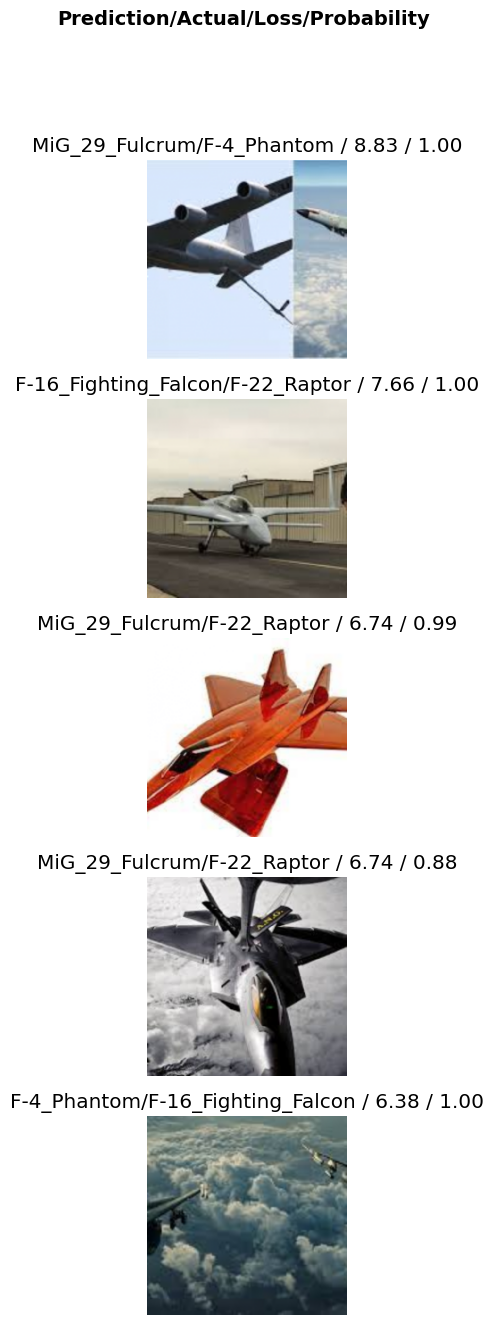

In [14]:
interp.plot_top_losses(5, nrows=5)

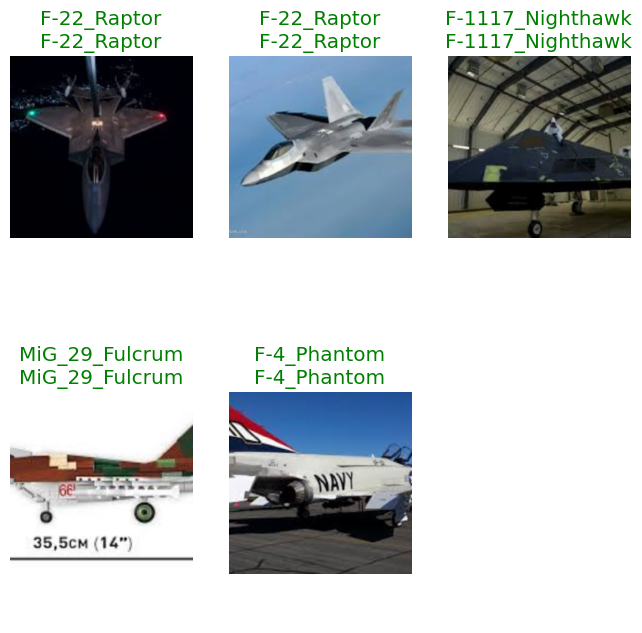

In [15]:
resnet50_model.show_results(max_n=5, figsize=(8,8))

In [16]:
confusion_matrix  = interp.confusion_matrix()

In [17]:
accuracies_per_class = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)

class_names = resnet50_model.dls.vocab

# Print accuracy per class
print('Accuracy per class:')
for i, accuracy in enumerate(accuracies_per_class):
    print(f'{class_names[i]}: {accuracy * 100:.2f}%')

Accuracy per class:
F-1117_Nighthawk: 96.43%
F-16_Fighting_Falcon: 81.25%
F-22_Raptor: 84.09%
F-4_Phantom: 70.59%
MiG_29_Fulcrum: 90.32%


In [16]:
accuracies_per_class = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)

class_names = resnet50_model.dls.vocab

# Print accuracy per class
print('Accuracy per class:')
for i, accuracy in enumerate(accuracies_per_class):
    print(f'{class_names[i]}: {accuracy * 100:.2f}%')

Accuracy per class:
F-1117_Nighthawk: 97.50%
F-16_Fighting_Falcon: 79.41%
F-22_Raptor: 93.55%
F-4_Phantom: 75.00%
MiG_29_Fulcrum: 73.08%


In [18]:
resnet50_model.export("./models/model50Extra")

In [19]:
loaded_model = load_learner("models/model50")

In [20]:
loaded_model.predict(path + 'F-22_Raptor/image_1.jpg')

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('F-22_Raptor',
 tensor(2),
 tensor([1.6581e-08, 1.3881e-09, 1.0000e+00, 2.6660e-11, 1.9414e-07]))

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

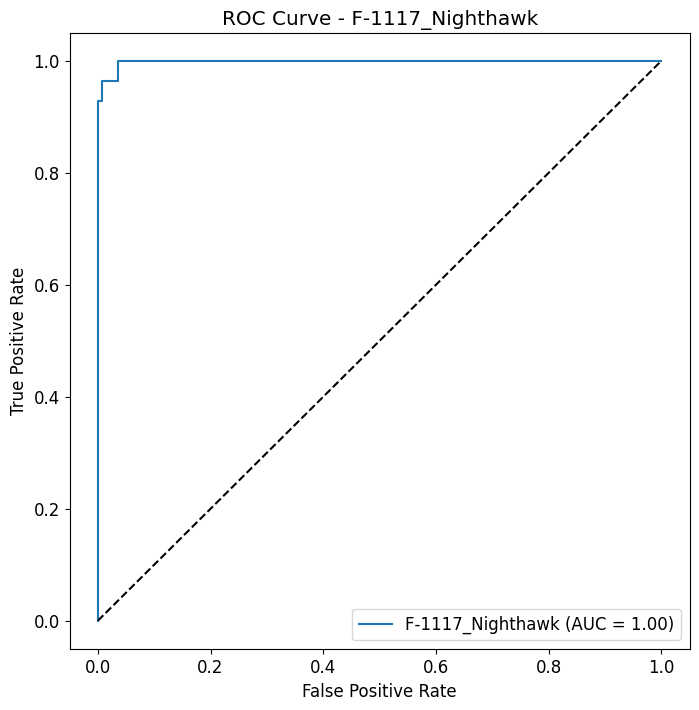

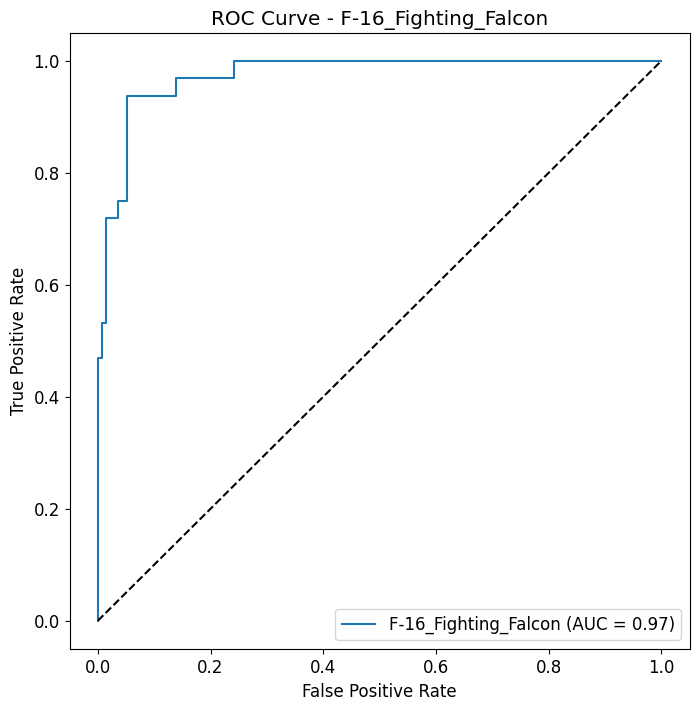

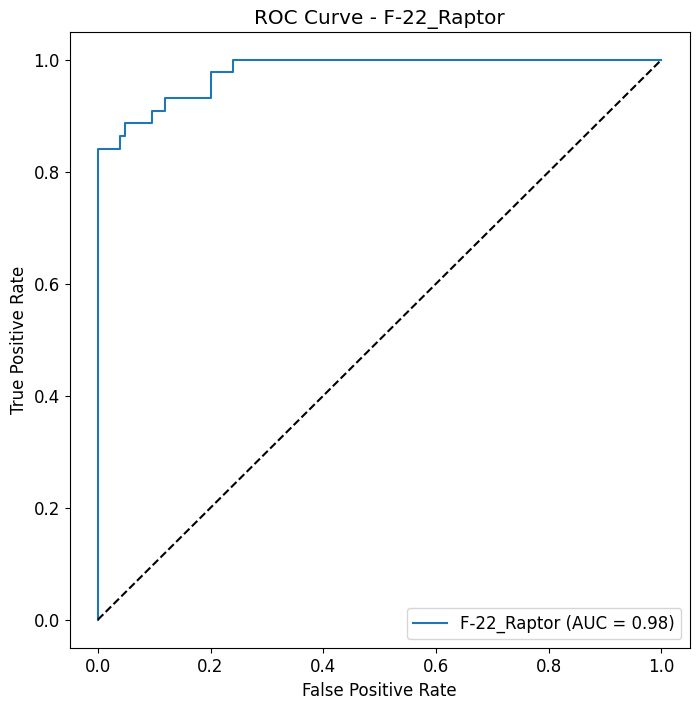

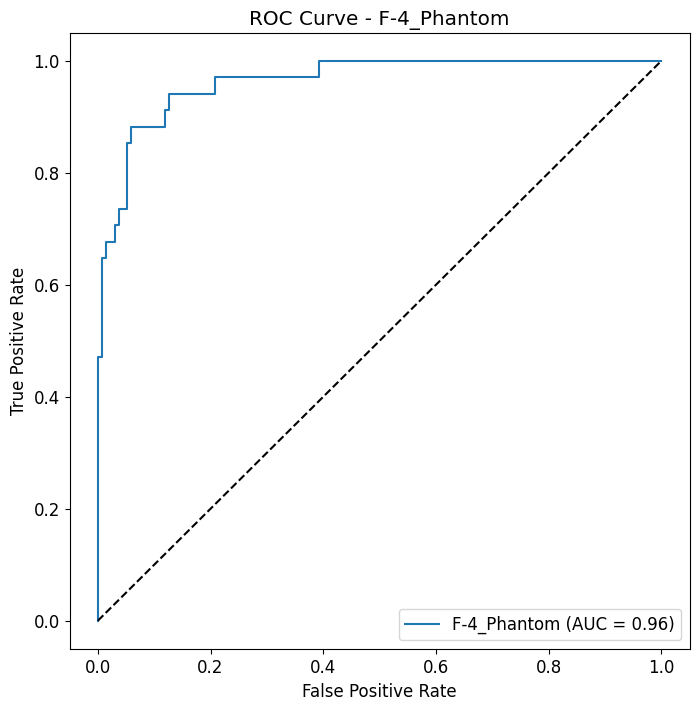

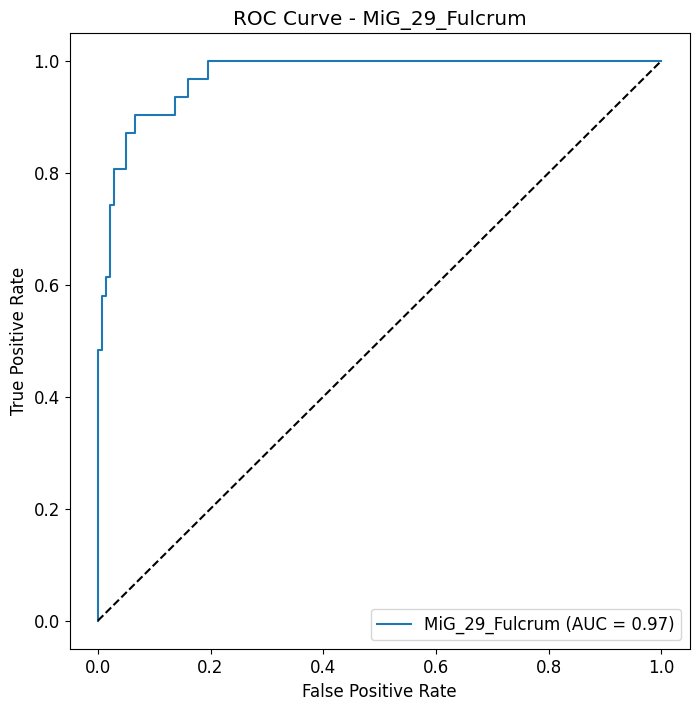

In [23]:
preds, targets = resnet50_model.get_preds()

# Check if it's a binary or multi-class problem
num_classes = preds.shape[1]
class_names = resnet50_model.dls.vocab

if num_classes > 1:
    # Convert targets to one-hot encoding for multi-class problems
    targets_onehot = F.one_hot(targets, num_classes=num_classes)
    
    # For multi-class problems, plot ROC-AUC for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(targets_onehot[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_names[i]}')
        plt.legend(loc='lower right')
        plt.show()

In [24]:
preds, targets = resnet50_model.get_preds()

# Check if it's a binary or multi-class problem
num_classes = preds.shape[1]

class_names = resnet50_model.dls.vocab

auc_values = []

if num_classes > 1:
    # Convert targets to one-hot encoding for multi-class problems
    targets_onehot = F.one_hot(targets, num_classes=num_classes)
    
    # For multi-class problems, compute ROC-AUC for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(targets_onehot[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
        
        auc_values.append((class_names[i], roc_auc))
else:
    # For binary classification problems, compute ROC-AUC
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    
    auc_values.append((class_names[1], roc_auc))

# Print AUC values
for class_name, auc_value in auc_values:
    print(f'AUC for {class_name}: {auc_value:.4f}')

d:\school23_24\.venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


AUC for F-1117_Nighthawk: 0.9985
AUC for F-16_Fighting_Falcon: 0.9742
AUC for F-22_Raptor: 0.9785
AUC for F-4_Phantom: 0.9636
AUC for MiG_29_Fulcrum: 0.9729
